In [27]:
import os
import json
import numpy as np
import datetime as dt
import math
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

# Initialization

## Set experiment dates

In [3]:
date_start = dt.datetime.strptime("2005-01-01", "%Y-%m-%d")
date_end = dt.datetime.strptime("2021-06-30", "%Y-%m-%d") 

## Set root directories

In [4]:
dir_root = os.path.join('..')
dir_data_processing = os.path.join(dir_root, "data_processing")
dir_data_runs = os.path.join(dir_root, "data_runs")

## Set reports directories

In [5]:
dir_reports_words = os.path.join(dir_data_processing, "reports_words")
dir_reports_terms = os.path.join(dir_data_processing, "reports_terms")
dir_reports_grams = os.path.join(dir_data_processing, "reports_gramms")
dir_reports_ready = os.path.join(dir_data_processing, "reports_ready")

## Set run directories

In [6]:
run_prefix = 'run_19-ext_22'
dir_run = os.path.join(dir_data_runs, run_prefix)
dir_result_interpretation = os.path.join(dir_run, 'interpretation')

## Set time series

In [7]:
year_series = list(range(date_start.year, date_end.year)) 

In [8]:
print(year_series)

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


# Build dictionary of a run

In [9]:
file_terms = os.path.join(dir_run, '%s-terms.dat' % run_prefix)

In [10]:
dictionary_term2id = {}
dictionary_id2term = {}
term_id_counter = 0
with open(file_terms, 'r') as f_r:
    for text_line in f_r:
        term = text_line.strip()
        dictionary_term2id[term] = term_id_counter
        dictionary_term2id[term_id_counter] = term
        term_id_counter += 1
        
print('Size of fixed dictionary: %s ' % term_id_counter)

Size of fixed dictionary: 21719 


# Construct binary reports vectors

## Read names of reports

In [11]:
def expand_report_info(name):
    name = name.strip().split('.')[0]
    components = name.split('-')
    year, index = components[1].split('_')
    
    return {
        'name': name,
        'year': int(year),
        'ticker': components[0],
        'index': int(index),
    }

In [12]:
reports = [] #{name, year, ticker, index}
tickers = set()
with open(os.path.join(dir_run, '%s-documents.dat' % run_prefix), 'r') as f_r:
    for line in f_r:
        report = expand_report_info(line)
        tickers.add(report['ticker'])
        reports.append(report)

tickers_list = list(sorted(tickers))        

print('Read %s reports' % len(reports))
print('Read %s tickers' % len(tickers))

Read 5562 reports
Read 79 tickers


## Map BOW to binary reports (P)

Read BOW for all reports

In [13]:
text_file = open(os.path.join(dir_run, '%s-mult.dat' % run_prefix), 'r')
reports_bow = text_file.readlines()

Construct P

In [14]:
P_by_year = {}

for ticker in tickers_list:
    p = {}
    for year in year_series:
        p[year] = np.zeros(term_id_counter)
    
    P_by_year[ticker] = p
    

for i, report in enumerate(reports):
    for j, term in enumerate(reports_bow[i].split(' ')):
        if j == 0: continue
        
        P_by_year[report['ticker']][report['year']][int(term.split(':')[0])] = 1
        

Test

In [15]:
test_ticker = 'AAL_FTSE'
test_year = 2007
total_term_in_P = 0
for appearance in P_by_year[test_ticker][test_year]:
    total_term_in_P += appearance 

    
print('%s in %s has %s unique terms' % (test_ticker, test_year, total_term_in_P))

AAL_FTSE in 2007 has 1886.0 unique terms


In [16]:
V_by_year = {}

for ticker in tickers_list:
    v = {}
    for year in year_series:
        v[year] = P_by_year[ticker][year] / np.sqrt(np.dot(P_by_year[ticker][year], np.ones(term_id_counter)))
        
    V_by_year[ticker] = v

In [17]:
test_ticker = 'AAL_FTSE'
test_year = 2007
v = None
    
print('%s in %s values in V scaled %s' % (test_ticker, test_year, np.max(V_by_year[test_ticker][test_year])))

AAL_FTSE in 2007 values in V scaled 0.0230265649529252


# Stability of a ticker (based on P)

Hamming distance

In [18]:
def hamming_distance(x, y, normalise=True):
    distance = 0
    size = max(x.sum(), y.sum())
    diff = np.logical_xor(x, y)
    distance = diff.sum() 
    if normalise:
        distance /= size
    
    return distance

Jaccard similarity

In [19]:
def jaccard_distance(x, y):
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    distance = intersection.sum() / float(union.sum())
    
    return distance

Hober-phillipps similarity

In [20]:
def hp_distance(x, y):
    distance = np.dot(x, y)
    
    return distance

# Hamming distance table

In [33]:
data = {}
for ticker in tickers_list:
    ticker_p_years = P_by_year[ticker]
    data_hamming = [0]
    for i in range(1, len(year_series)):
        data_hamming.append(
            hamming_distance(ticker_p_years[year_series[i - 1]],
            ticker_p_years[year_series[i]],
            normalise=False))
    data[ticker] = data_hamming
    
df_data = pd.DataFrame(
            data = data,
            columns=tickers_list)    
    

In [34]:
print(df_data)

    AAL_FTSE  ACA_CAC  AC_CAC  ADM_FTSE  AGK_FTSE  AIR_CAC  ALV_DAX  \
0          0        0       0         0         0        0        0   
1        872     1269     908       794       344     1028      424   
2        974     1060    1120       565       197      982     1405   
3       1045     1259     165       488       245     1012     1445   
4       1004     1251     133       736       413     1417     1709   
5       1058     1212     290       775       491     1753     1114   
6       1162     1203     283       593       479      888     1314   
7       1142     1198     206       522       282     1624     1153   
8       1260     1370     239       584       333      826     1470   
9       1297     1381     255       765      1359     1190     1260   
10      1169     1191     331       685      1533     1086      927   
11      1051     1084     709       773      1247     1873     1017   
12       938     1113     772       798       791      438      808   
13    

Plot distance between consecutive

In [39]:
rows_on_page = 5
columns_on_page = 2
plots_on_page = rows_on_page * columns_on_page
number_of_pages = math.ceil(len(tickers) / plots_on_page)

In [40]:
dir_hp_distance_plots = os.path.join(dir_result_interpretation, 'hoberg_phillipps_distance_plot')

if not os.path.exists(dir_hp_distance_plots):
    os.makedirs(dir_hp_distance_plots)

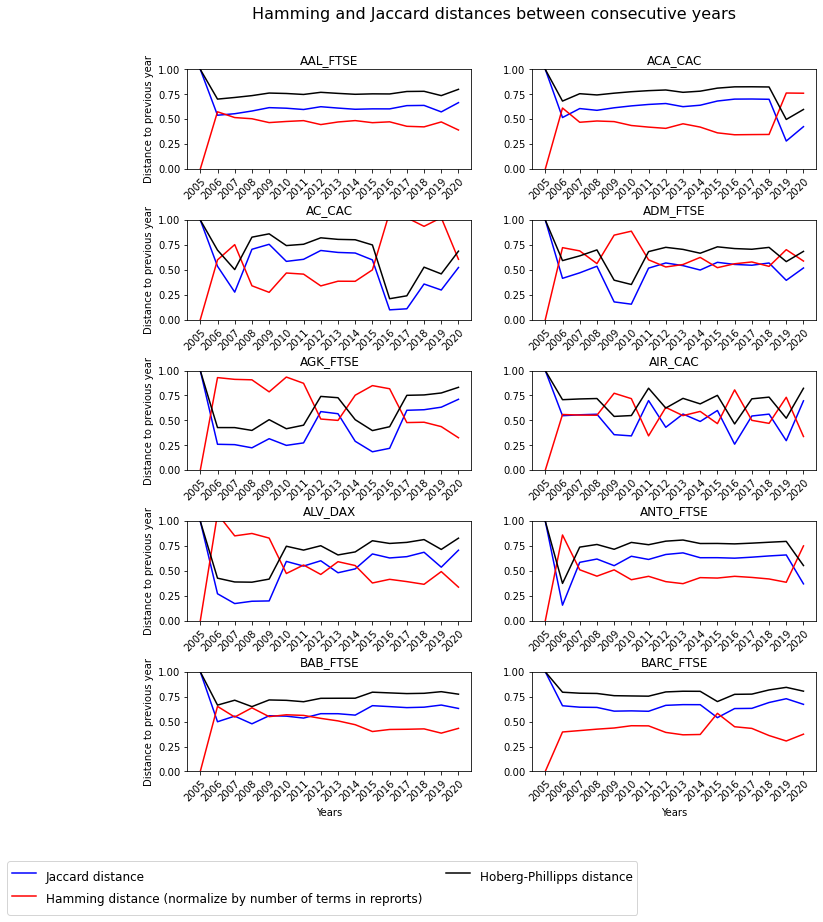

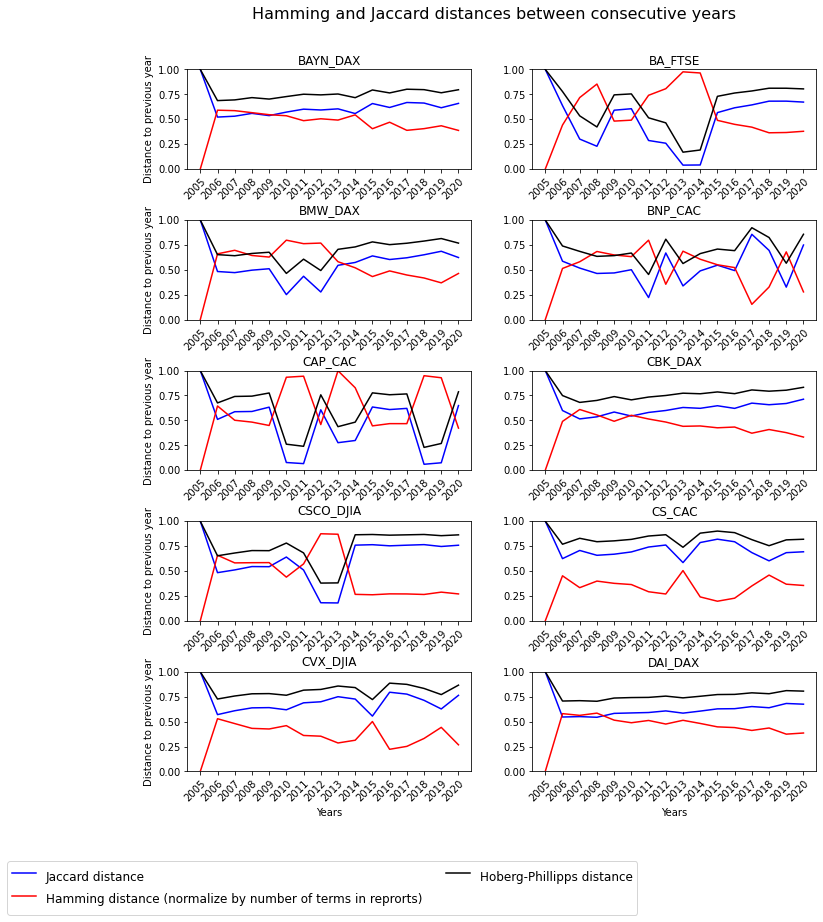

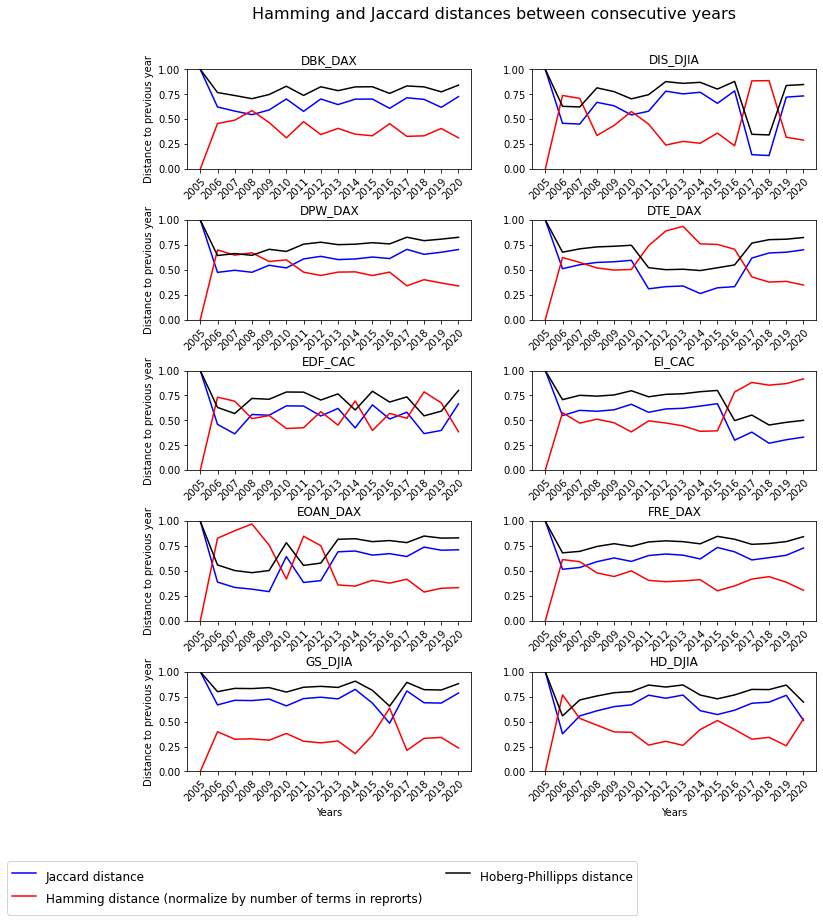

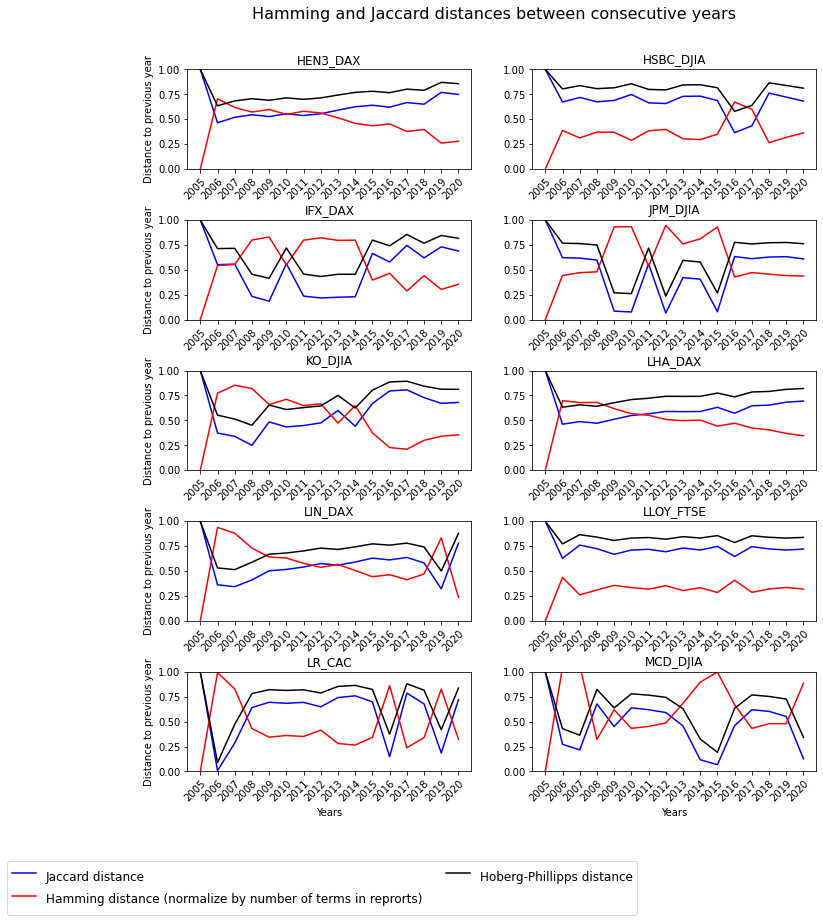

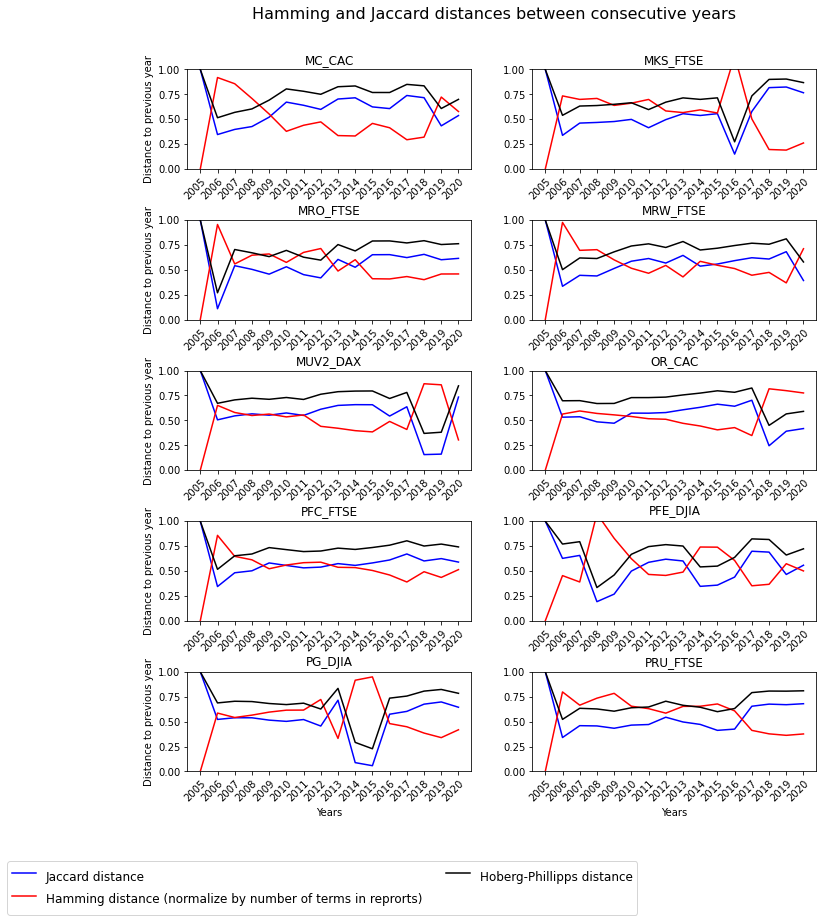

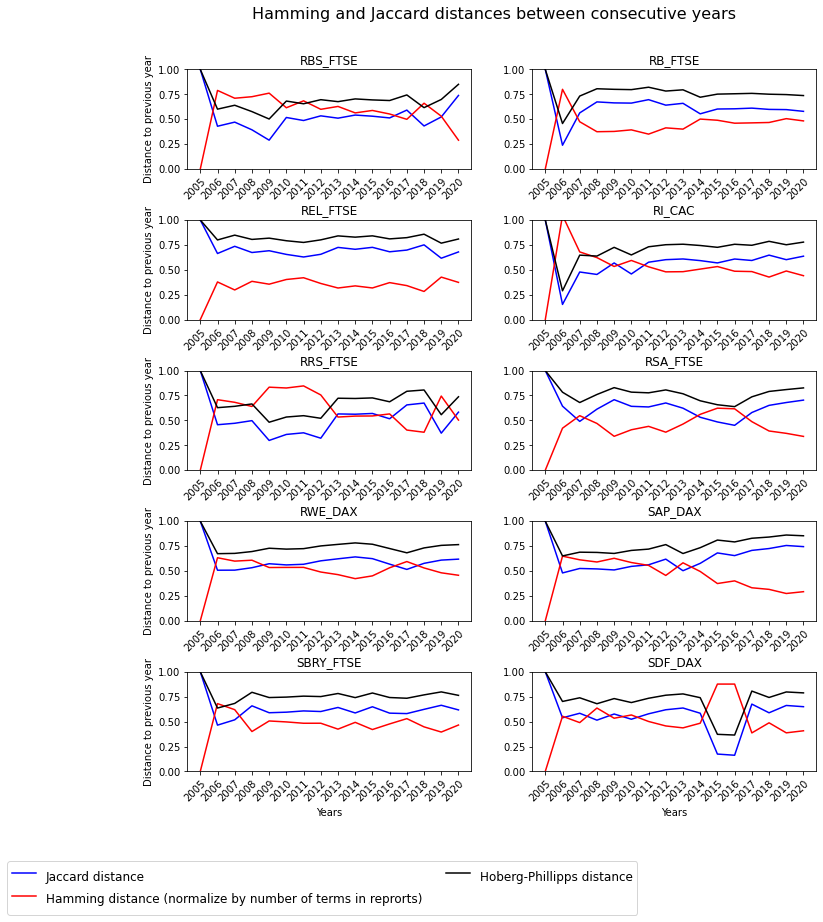

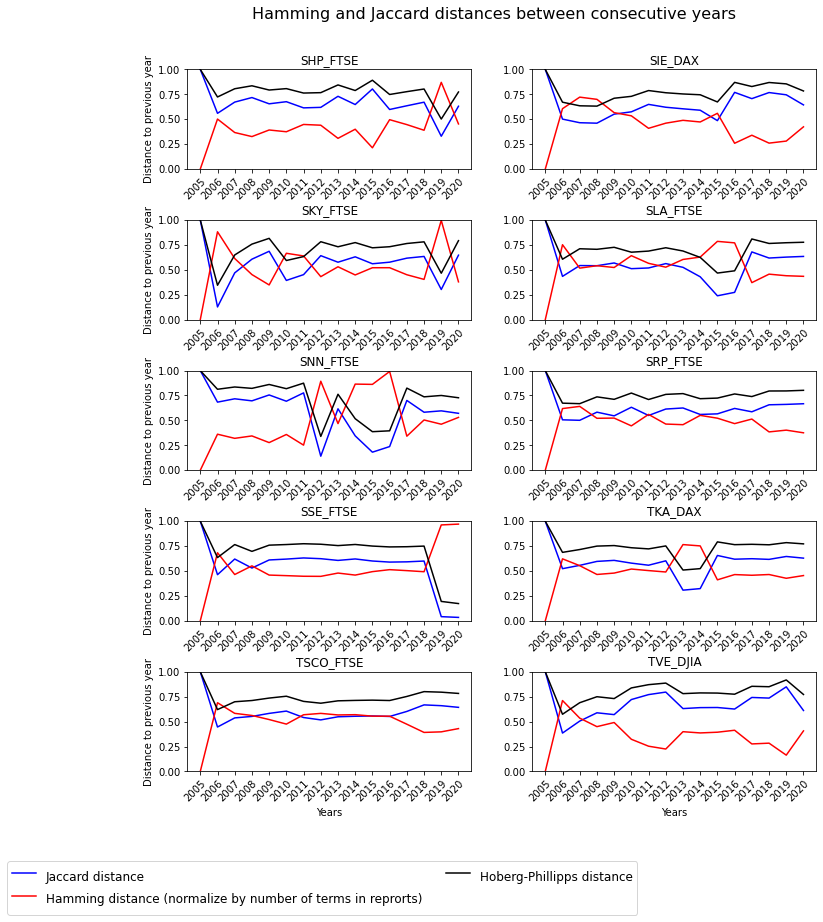

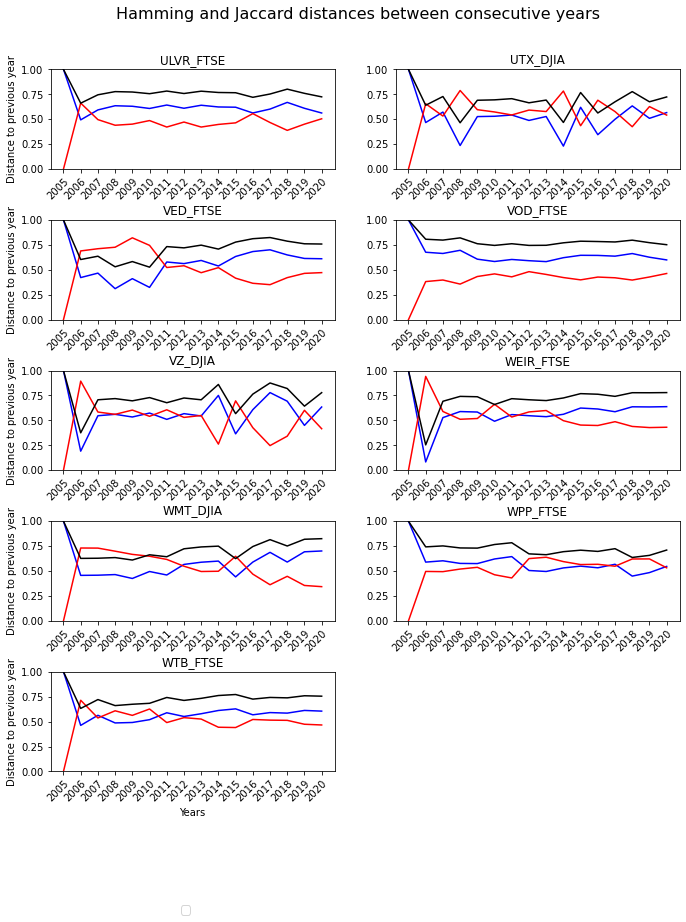

In [43]:
global_ticker_iterator = 0

bar_width = 1
bar_l = [i for i in range(len(year_series))]
tick_pos = [i for i in bar_l]

for page in range(number_of_pages):
    
    f, axs = plt.subplots(
        rows_on_page,
        columns_on_page,
        figsize=(10,11.5), # A4 landscape(11.69,8.27)
        ) 
    
    f.suptitle('Hamming and Jaccard distances between consecutive years', fontsize=16)
    f.tight_layout(pad=3.0)
    for row_index in range(rows_on_page):
        for column_index in range(columns_on_page):
            ax = axs[row_index][column_index]
            
            if global_ticker_iterator >= len(tickers_list):
                ax.axis('off')
                continue

            if column_index == 0:
                ax.set_ylabel("Distance to previous year")
            if row_index ==  rows_on_page - 1:
                ax.set_xlabel("Years")
                
            ticker = tickers_list[global_ticker_iterator]
            ax.set_title('%s' % (ticker))


            # data construction
            ticker_p_years = P_by_year[ticker]
            ticker_v_years = V_by_year[ticker]            
            ## jaccard
            data_jaccard = [1]
            for i in range(1, len(year_series)):
                data_jaccard.append(jaccard_distance(ticker_p_years[year_series[i - 1]], ticker_p_years[year_series[i]]))
            ax.plot(np.asarray(data_jaccard, dtype=np.float64), color='blue', label='Jaccard distance')
            
            ## hamming
            data_hamming = [0]
            for i in range(1, len(year_series)):
                data_hamming.append(hamming_distance(ticker_p_years[year_series[i - 1]], ticker_p_years[year_series[i]]))
            ax.plot(np.asarray(data_hamming, dtype=np.float64), color='red', label='Hamming distance (normalize by number of terms in reprorts)')
            
            ## hamming
            data_hp_sim = [1]
            for i in range(1, len(year_series)):
                data_hp_sim.append(hp_distance(ticker_v_years[year_series[i - 1]], ticker_v_years[year_series[i]]))
            ax.plot(np.asarray(data_hp_sim, dtype=np.float64), color='black', label='Hoberg-Phillipps distance')
            
            ax.set_ylim(0, 1)
            ax.set_xticks(tick_pos)
            ax.set_xticklabels(year_series, rotation=45, rotation_mode="anchor", horizontalalignment='right')
            
            global_ticker_iterator += 1
            
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, 
        bbox_to_anchor=(-0.74, -1.5), 
        loc="lower center", 
        ncol=2, 
        handleheight=2.4, 
        labelspacing=0.05, prop={'size': 12})
        
    #save plot
    pp = PdfPages(os.path.join(dir_hp_distance_plots, 'hp_similarity_on_page_%s.pdf' % page))
    plt.savefig(pp, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    pp.close()
    
    plt.show()
    plt.close()


Create a df with hamming distance

In [42]:
print(tickers_list)

['AAL_FTSE', 'ACA_CAC', 'AC_CAC', 'ADM_FTSE', 'AGK_FTSE', 'AIR_CAC', 'ALV_DAX', 'ANTO_FTSE', 'BAB_FTSE', 'BARC_FTSE', 'BAYN_DAX', 'BA_FTSE', 'BMW_DAX', 'BNP_CAC', 'CAP_CAC', 'CBK_DAX', 'CSCO_DJIA', 'CS_CAC', 'CVX_DJIA', 'DAI_DAX', 'DBK_DAX', 'DIS_DJIA', 'DPW_DAX', 'DTE_DAX', 'EDF_CAC', 'EI_CAC', 'EOAN_DAX', 'FRE_DAX', 'GS_DJIA', 'HD_DJIA', 'HEN3_DAX', 'HSBC_DJIA', 'IFX_DAX', 'JPM_DJIA', 'KO_DJIA', 'LHA_DAX', 'LIN_DAX', 'LLOY_FTSE', 'LR_CAC', 'MCD_DJIA', 'MC_CAC', 'MKS_FTSE', 'MRO_FTSE', 'MRW_FTSE', 'MUV2_DAX', 'OR_CAC', 'PFC_FTSE', 'PFE_DJIA', 'PG_DJIA', 'PRU_FTSE', 'RBS_FTSE', 'RB_FTSE', 'REL_FTSE', 'RI_CAC', 'RRS_FTSE', 'RSA_FTSE', 'RWE_DAX', 'SAP_DAX', 'SBRY_FTSE', 'SDF_DAX', 'SHP_FTSE', 'SIE_DAX', 'SKY_FTSE', 'SLA_FTSE', 'SNN_FTSE', 'SRP_FTSE', 'SSE_FTSE', 'TKA_DAX', 'TSCO_FTSE', 'TVE_DJIA', 'ULVR_FTSE', 'UTX_DJIA', 'VED_FTSE', 'VOD_FTSE', 'VZ_DJIA', 'WEIR_FTSE', 'WMT_DJIA', 'WPP_FTSE', 'WTB_FTSE']
